# Introduction to Convolutional Neural Networks with Keras 

### The data set used: CIFAR10
https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from keras.datasets import cifar10
from keras import optimizers, losses
import keras.utils
from keras.utils import to_categorical
from keras import utils as np_utils
from keras.models import model_from_json
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
#load the data, we won't use now the test set
(x_train, y_train), ( x_test , y_test) = cifar10.load_data() #the _ indicates we don't want that value

## Understanding the data_set
The training set has 50000 images RGB each of shape 32x32x3 (x_train) and 5000 labels (y_train). 
The test set has 1000 images with the same especifications.
0. airplane 										
1. automobile 										
2. bird 										
3. cat 										
4. deer 										
5. dog 										
6. frog 										
7. horse 										
8. ship 										
9. truck 										
 

In [3]:
#Dividing the training set into test set and validation set
x_test = x_train[45000:50000]
y_test = y_train[45000: 50000]
x_train = x_train[0:45000]
y_train = y_train[0: 45000]

label:  [9] truck
x_train.shape =  (45000, 32, 32, 3)
y_train.shape =  (45000, 1)
y_test.shape =  (5000, 32, 32, 3)
y_test.shape =  (5000, 1)
number of classes:  10


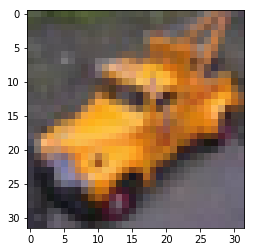

In [4]:
#Extracting sizes
m = x_train.shape[0]
width =  x_train.shape[2] #the width is the number of columns
height = x_train.shape[1] #the height is the number of lines
n_C = x_train.shape[3]

#View the data
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
index = np.random.randint(m)
img = x_train[index]
print("label: ", y_train[index], classes[int(y_train[index])])
imgplot = plt.imshow(img)

print ("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("y_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)
print("number of classes: ", np.max(y_train) + 1)

## Conv2D
**keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)**  
2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last".


* filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
* kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
* strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
* padding: one of "valid" or "same" (case-insensitive).
    
https://keras.io/layers/convolutional/

## My ConvModel
input => 16 filters of 3x3 stride 1, no padding => 1 POOL layer 2x2 stride 2 => 8 filters 5x5x16 stride 2 = Flatten =>
volume.reshape(volume.shape[0], -1).T => FC 20 nodes => softmax() with 10 outputs. 
Some things to look carefully:

In [5]:
num_classes = 10
model = Sequential()
#layer 1
initializer = keras.initializers.he_normal(1)
model.add(Conv2D(16, 3, strides = 1, input_shape = x_train[0].shape,
                 padding = 'valid', activation = 'relu', kernel_initializer = initializer))
#layer 2
model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
#layer 3
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer = initializer))
model.add(Flatten())
#layer 4
model.add(Dense(30, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [6]:
#learning rate
lr = 0.0000002
optimizer = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= optimizer,
              metrics=['accuracy'])


## Use one hot enconding
Why use one hor enconding?
The categorical varibles representation become more expressive.  
See the refference to implementations in some frameworks.
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

## Traning model:

In [ ]:
#uses one hot encoding on the labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)


batch_size = 64 #this is the default by the way
epochs = 10
tic = time.time()
history = loaded_model.fit(x_train, y_train_encoded,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test_encoded),
          )
toc = time.time()
elapsed_time = toc - tic
print("Elapsed time: ", elapsed_time)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 45s 993us/step - loss: 13.2261 - acc: 0.1785 - val_loss: 13.4616 - val_acc: 0.1612
Epoch 2/10
45000/45000 [==============================] - 46s 1ms/step - loss: 13.2261 - acc: 0.1786 - val_loss: 13.4609 - val_acc: 0.1612
Epoch 3/10
45000/45000 [==============================] - 44s 975us/step - loss: 13.2261 - acc: 0.1785 - val_loss: 13.4611 - val_acc: 0.1612
Epoch 4/10
45000/45000 [==============================] - 44s 974us/step - loss: 13.2261 - acc: 0.1785 - val_loss: 13.4612 - val_acc: 0.1612
Epoch 5/10
45000/45000 [==============================] - 45s 994us/step - loss: 13.2260 - acc: 0.1785 - val_loss: 13.4612 - val_acc: 0.1614
Epoch 6/10
45000/45000 [==============================] - 46s 1ms/step - loss: 13.2260 - acc: 0.1785 - val_loss: 13.4614 - val_acc: 0.1614
Epoch 7/10
44416/45000 [============================>.] - ETA: 0s - loss: 13.2315 - acc: 0.1783

## Visualizing the Results
1. Plot the accuracy per epoch
2. Plot the cost function per epoch

In [8]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

## Loading and evaluating weights and model from the disk

In [19]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

#EVALUATE MODEL
# evaluate loaded model on test data
lr = 0.00000005
optimizer = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= optimizer,
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test_encoded, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 16.12%


The prediction:  4 deer
The label:  [0] airplane


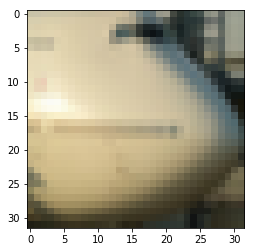

In [10]:
score = model.evaluate(x_test, y_test_encoded, verbose=0)
## Prediction time
index = np.random.randint(x_test.shape[0])
X_predict = x_test[index]
x_shape = X_predict.shape
X_predict = X_predict.reshape((1, X_predict.shape[0], X_predict.shape[1], X_predict.shape[2]))
y_predict = model.predict_classes(X_predict)
y_predict = int(y_predict.reshape(1))
print("The prediction: ", y_predict, classes[y_predict])
print( "The label: ", y_test[index], classes[int(y_test[index])])
plt.imshow(X_predict.reshape(x_shape))

## Saving model and weights to disk

Tutorial to save the model and the weights to disk.
https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [11]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## References:
http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

Initialize parameters:
https://keras.io/optimizers/

Optimizers:
https://keras.io/optimizers/

Counting time:  
https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module

Visualizing the data:  
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

Making predictions:
https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/

## Problems:
**In exp02**:
Add he-inititializer, use the training set with 45000 examples and the validation set with 5000.
Why change: I think the model is falling at breaking symetry. (it didn't break symetry)

**In exp03**:
keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004.The cost does not get lower on epochs. Possilble problem, gradient vanishing. Solution: ResNet?
**In exp04**: increase number of neurons in the FC layer.
